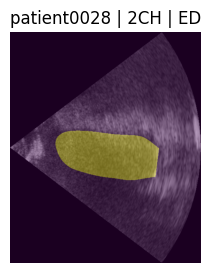

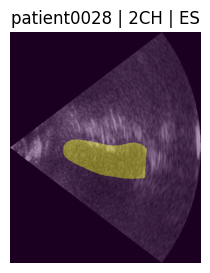

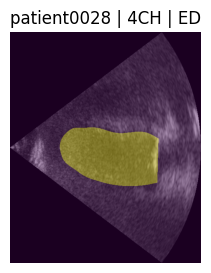

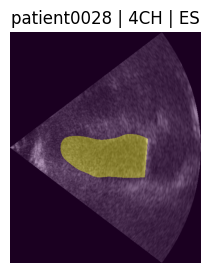

LV area (pixels): 20402


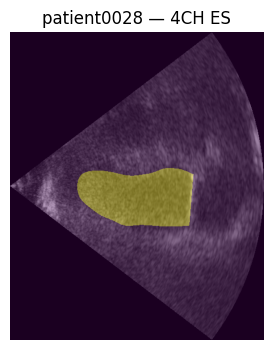

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# ============================================================
# HELPER: LOAD CAMUS LV GROUND-TRUTH MASK
# ============================================================

import nibabel as nib
import numpy as np
import os

def get_lv_mask(pid, view="2CH", phase="ED", source="gt"):
    """
    Returns binary LV mask from CAMUS ground-truth NIFTI files
    """
    if source != "gt":
        raise ValueError("Only GT masks supported")

    mask_path = f"database_nifti/{pid}/{pid}_{view}_{phase}_gt.nii.gz"

    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    mask = nib.load(mask_path).get_fdata()
    return mask == 1  # LV label

pid = "patient0028"
#pid =  "whoever"
for view in ["2CH", "4CH"]:
    for phase in ["ED", "ES"]:
        img = nib.load(
            f"database_nifti/{pid}/{pid}_{view}_{phase}.nii.gz"
        ).get_fdata()

        lv_mask = get_lv_mask(pid, view=view, phase=phase, source="gt")

        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap="gray")
        plt.imshow(lv_mask, alpha=0.4)
        plt.title(f"{pid} | {view} | {phase}")
        plt.axis("off")
        plt.show()
        
def get_lv_mask(pid, view="2CH", phase="ED", source="gt"):
    """
    Returns a boolean LV cavity mask.
    """
    if source == "gt":
        mask = nib.load(
            f"database_nifti/{pid}/{pid}_{view}_{phase}_gt.nii.gz"
        ).get_fdata()
        return mask == 1

# Load image
img = nib.load(
    f"database_nifti/{pid}/{pid}_{view}_{phase}.nii.gz").get_fdata()

# Get LV mask (THIS is the abstraction you wanted)
lv_mask = get_lv_mask(pid, view=view, phase=phase, source="gt")

# Compute area in pixels
lv_area_pixels = lv_mask.sum()
print("LV area (pixels):", lv_area_pixels)

# Visualize overlay
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap="gray")
plt.imshow(lv_mask, alpha=0.4)
plt.title(f"{pid} — {view} {phase}")
plt.axis("off")
plt.show()


In [2]:
def lv_area_mm2(pid, view="2CH", phase="ED"):
    base = f"database_nifti/{pid}"
    
    img_nii = nib.load(f"{base}/{pid}_{view}_{phase}.nii.gz")
    mask = nib.load(f"{base}/{pid}_{view}_{phase}_gt.nii.gz").get_fdata()
    
    # Pixel spacing (mm)
    dx, dy = img_nii.header.get_zooms()[:2]
    pixel_area = dx * dy  # mm²
    
    lv_pixels = (mask == 1).sum()
    return lv_pixels * pixel_area

In [3]:
for phase in ["ED", "ES"]:
    area = lv_area_mm2(pid, "2CH", phase)
    print(f"2CH {phase} area (mm²): {area:.1f}")

2CH ED area (mm²): 2499.2
2CH ES area (mm²): 1509.6


In [4]:
def lv_volume_proxy(pid, phase="ED"):
    A2 = lv_area_mm2(pid, "2CH", phase)
    A4 = lv_area_mm2(pid, "4CH", phase)
    return np.sqrt(A2 * A4)
EDV = lv_volume_proxy(pid, "ED")
ESV = lv_volume_proxy(pid, "ES")

print("EDV proxy:", EDV)
print("ESV proxy:", ESV)

EDV proxy: 2700.5846799876585
ESV proxy: 1709.2823859753764


In [5]:
SV = EDV - ESV
print("Stroke volume (proxy units):", SV)
EF = SV / EDV
print("Ejection fraction (proxy):", EF)

Stroke volume (proxy units): 991.3022940122821
Ejection fraction (proxy): 0.3670695095614674


In [6]:
def lv_length_mm(pid, view="4CH", phase="ED"):
    base = f"database_nifti/{pid}"
    img_nii = nib.load(f"{base}/{pid}_{view}_{phase}.nii.gz")
    mask = nib.load(f"{base}/{pid}_{view}_{phase}_gt.nii.gz").get_fdata()
    dx, dy = img_nii.header.get_zooms()[:2]
    ys, xs = np.where(mask == 1)
    # approximate long axis as max distance between LV pixels
    length_pixels = np.sqrt(
        (xs.max() - xs.min())**2 +
        (ys.max() - ys.min())**2 )
    return length_pixels * np.mean([dx, dy])  # mm

In [7]:
def lv_volume_ml(pid, phase="ED"):
    A2 = lv_area_mm2(pid, "2CH", phase)
    A4 = lv_area_mm2(pid, "4CH", phase)
    L = lv_length_mm(pid, "4CH", phase)
    
    V_mm3 = (8 / (3 * np.pi)) * (A2 * A4) / L
    return V_mm3 / 1000  # mm³ → mL

EDV = lv_volume_ml(pid, "ED")
ESV = lv_volume_ml(pid, "ES")
SV  = EDV - ESV

print(f"EDV: {EDV:.1f} mL")
print(f"ESV: {ESV:.1f} mL")
print(f"Stroke Volume: {SV:.1f} mL")

EDV: 68.9 mL
ESV: 32.4 mL
Stroke Volume: 36.4 mL


In [8]:
def cardiac_output_L_min(SV_ml, HR_bpm):
    return (SV_ml * HR_bpm) / 1000  # mL/min → L/min
HR = 80  # bpm
CO = cardiac_output_L_min(SV, HR)
print(f"Cardiac Output @ {HR} bpm: {CO:.2f} L/min")

Cardiac Output @ 80 bpm: 2.91 L/min


In [9]:
def lvot_area_cm2(d_cm):
    return np.pi * (d_cm / 2)**2
def vti_equivalent_cm(SV_ml, lvot_d_cm):
    A = lvot_area_cm2(lvot_d_cm)  # cm²
    SV_cm3 = SV_ml  # 1 mL = 1 cm³
    return SV_cm3 / A

d_vals = np.linspace(1.4, 2.2, 9)  # cm

for d in d_vals:
    vti = vti_equivalent_cm(SV, d)
    print(f"d={d:.2f} cm → VTI={vti:.1f} cm")

d=1.40 cm → VTI=23.7 cm
d=1.50 cm → VTI=20.6 cm
d=1.60 cm → VTI=18.1 cm
d=1.70 cm → VTI=16.0 cm
d=1.80 cm → VTI=14.3 cm
d=1.90 cm → VTI=12.8 cm
d=2.00 cm → VTI=11.6 cm
d=2.10 cm → VTI=10.5 cm
d=2.20 cm → VTI=9.6 cm
